<a href="https://colab.research.google.com/github/Vlad12344/Kaggle-Quick-Draw/blob/master/MobileNet_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import os
import ast
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.models import Sequential
from tensorflow import set_random_seed
from keras.applications import MobileNet
from PIL import Image, ImageDraw, ImageOps
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.mobilenet import preprocess_input
from IPython.core.interactiveshell import InteractiveShell
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy

InteractiveShell.ast_node_interactivity = "all"
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14

from google.colab import drive
drive.mount('/content/drive/')

Using TensorFlow backend.


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
DP_DIR = '/content/drive/My Drive/colab/shuffle_csvs'
INPUT_DIR = '/content/drive/My Drive/colab'

BASE_SIZE = 256
NCSVS = 100
NCATS = 340
np.random.seed(seed=1987)
set_random_seed(seed=1987)

def f2cat(filename: str) -> str:
    return filename.split('.')[0]

def list_all_categories():
    files = np.load(INPUT_DIR)
    return sorted([f2cat(f) for f in files], key=str.lower)

In [0]:
def apk(actual, predicted, k=3):
   
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [0]:
STEPS = 800
EPOCHS = 16
size = 64
batchsize = 1020

In [0]:
model = MobileNet(input_shape=(size, size, 1), alpha=1., weights=None, classes=NCATS)
model.compile(optimizer=Adam(lr=0.002), loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img
    
def image_generator_xd(size, batchsize, ks, lw=6, time_color=True):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing'] = df['drawing'].apply(ast.literal_eval)
                x = np.zeros((len(df), size, size, 1))
                for i, raw_strokes in enumerate(df.drawing.values):
                    x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw)
                x = preprocess_input(x).astype(np.float32)
                y = np_utils.to_categorical(df.y, num_classes=NCATS)
                yield x, y
        
def df_to_image_array_xd(df, size, lw=6, time_color=True):
    df['drawing'] = df['drawing'].apply(ast.literal_eval)
    x = np.zeros((len(df), size, size, 1))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw)
    x = preprocess_input(x).astype(np.float32)
    return x

In [7]:
valid_df = pd.read_csv(os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(NCSVS - 1)), nrows=34000)
x_valid = df_to_image_array_xd(valid_df, size)
y_valid = np_utils.to_categorical(valid_df.y, num_classes=NCATS)
print(x_valid.shape, y_valid.shape)
print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3 ))

(34000, 64, 64, 1) (34000, 340)
Validation array memory 0.52 GB


In [0]:
train_datagen = image_generator_xd(size=size, batchsize=batchsize, ks=range(NCSVS - 1))

In [9]:
callbacks = [
    ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5,
                      min_delta=0.005, mode='max', cooldown=3, verbose=1)]

hists = []
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,
    validation_data=(x_valid, y_valid), callbacks=callbacks)
hists.append(hist)

Epoch 1/16
800/800 [==============================] - 591s 738ms/step - loss: 2.5499 - acc: 0.4204 - val_loss: 3.0259 - val_acc: 0.3624
Epoch 2/16


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1109: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_categorical_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


800/800 [==============================] - 584s 729ms/step - loss: 1.5445 - acc: 0.6156 - val_loss: 2.0888 - val_acc: 0.5014
Epoch 3/16
800/800 [==============================] - 591s 739ms/step - loss: 1.3316 - acc: 0.6640 - val_loss: 1.5795 - val_acc: 0.6120
Epoch 4/16
800/800 [==============================] - 583s 729ms/step - loss: 1.2466 - acc: 0.6835 - val_loss: 1.5288 - val_acc: 0.6222
Epoch 5/16
800/800 [==============================] - 586s 733ms/step - loss: 1.1847 - acc: 0.6986 - val_loss: 1.3742 - val_acc: 0.6529
Epoch 6/16
800/800 [==============================] - 589s 736ms/step - loss: 1.1447 - acc: 0.7077 - val_loss: 1.2331 - val_acc: 0.6854
Epoch 7/16
800/800 [==============================] - 582s 727ms/step - loss: 1.1068 - acc: 0.7163 - val_loss: 1.2446 - val_acc: 0.6803
Epoch 8/16
800/800 [==============================] - 590s 738ms/step - loss: 1.0767 - acc: 0.7238 - val_loss: 2.9317 - val_acc: 0.3691
Epoch 9/16
800/800 [==============================] - 587s 

In [10]:
model.save_weights(os.path.join(INPUT_DIR, 'quick_doodle_Mobi_generator_64.h5'))

model_json = model.to_json()
# Записываем модель в файл
json_file = open(os.path.join(INPUT_DIR, 'quick_doodle_Mobi_generator_64.json'), 'w')
json_file.write(model_json)
json_file.close()

43380

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

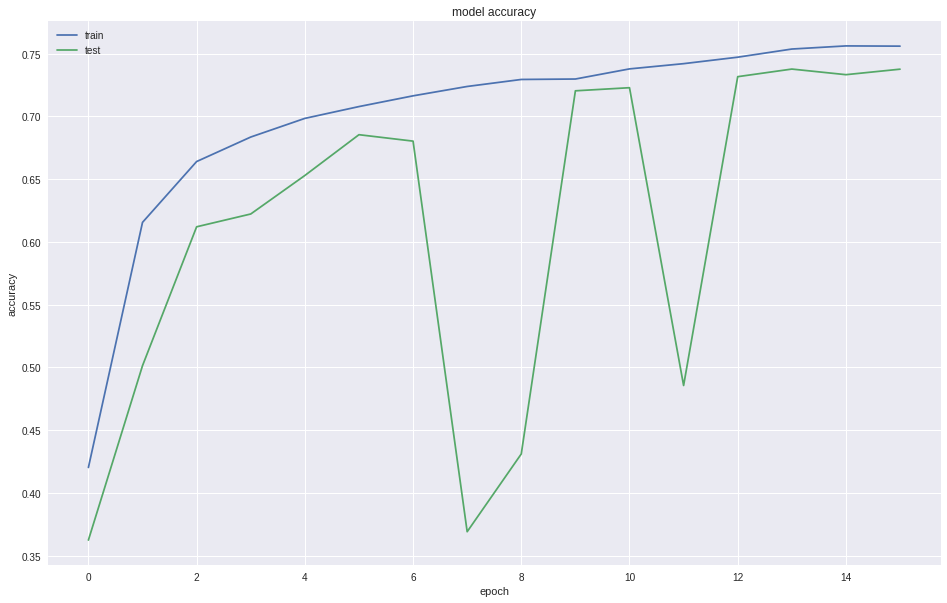

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

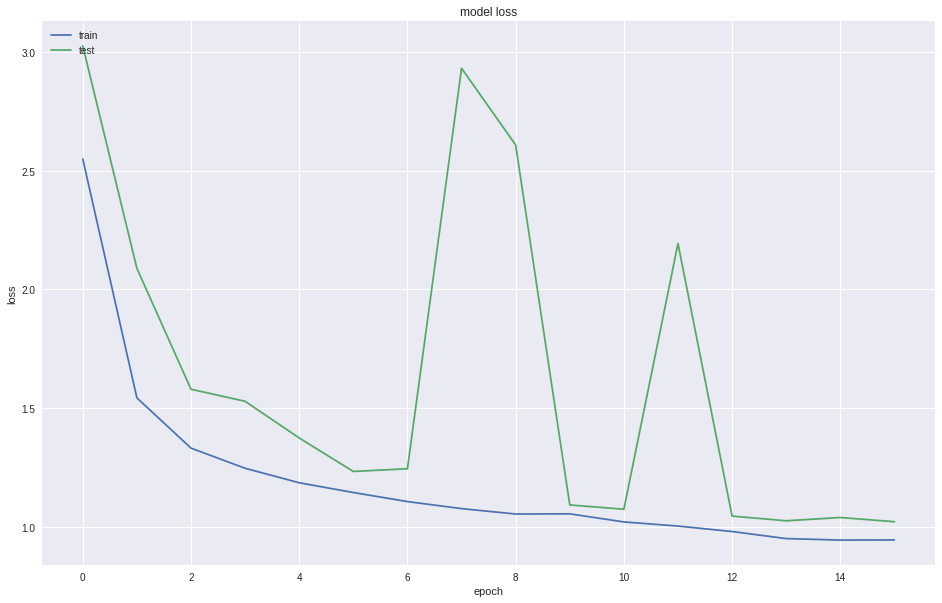

In [20]:
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()